# LUNA Basic Tutorial #2 - Generating fingerprints and running multiple jobs

This tutorial will cover: 
* Running multiple jobs sequentially vs in parallel
* Generate different flavors of IFP and convert them to RDKit-like objects and then compute Tanimoto similarity
* Plotting heatmaps for summarizing the interactions
* Plotting a Pymol session for superposed complexes

In [1]:
import matplotlib.pyplot as plt
import multiprocessing as mp
import time

### Set up system paths and import LUNA

In [2]:
LUNApath = '/srv/home/lshub/LUNA' #change this to point to LUNA directory

import sys
sys.path.append(LUNApath)

import luna

RDKit WARNING: [11:36:53] Enabling RDKit 2019.09.3 jupyter extensions
/srv/home/lshub/miniconda3/envs/luna-env/lib/python3.7/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')


**<ins>NOTE:</ins> in luna/util/default_values.py, change the OPENBABEL default location from 
    "/usr/bin/obabel" to location of obabel executable**

### Setting up entries and PDB folder

In [3]:
from luna.mol.entry import MolEntry

In [4]:
input_path = "./inputs_multi"
output_path = "./outputs"

In [5]:
!ls "./inputs_multi"

lig0.mol  lig1.mol  lig2.mol  lig3.mol	lig4.mol  lig5.mol  lig6.mol  prot.pdb


#### Note: These entries all use the same receptor pdb file. If you have different pdb files for each ligand, make sure to define each entry with the correct corresponding pdb name.

In [6]:
entries = []

for i in range(7):
    entry = MolEntry.from_mol_file("prot", f"lig{i}", f"./inputs_multi/lig{i}.mol", 
                mol_obj_type='rdkit', is_multimol_file=False)
    entries.append(entry)

### Calculating interaction fingerprints

#### Setting up parameters

In [7]:
opt = {}

opt['entries'] = entries
opt['working_path'] = output_path
opt['pdb_path'] = input_path

opt['overwrite_path'] = False
opt['try_h_addition'] = True
opt['ph'] = 7.4
opt['amend_mol'] = False

opt['mol_obj_type'] = 'rdkit'
opt['verbosity'] = 2 # How verbose is the logger

In [8]:
from luna.mol.interaction.filter import InteractionFilter
from luna.mol.interaction.calc import InteractionCalculator

In [9]:
pli_filter = InteractionFilter.new_pli_filter()
opt['inter_calc'] = InteractionCalculator(inter_filter=pli_filter)

### Fingerprint options

In [10]:
opt['calc_mfp'] = False #molecular fingerprint
opt['calc_ifp'] = True #interaction fingerprint
#opt['ifp_count'] = True #choose between count and bit fingerprint

opt["ifp_num_levels"] = 7 # IFP parameter: number of levels
opt["ifp_radius_step"] = 1 # IFP parameter: radius growth
opt["ifp_length"] = 2048 # IFP parameter: size of the fingerprint

### Determine how many processes to run in parallel

By default, jobs are run in parallel, with up to NPROC simultaneous processes. NPROC depends on the CPU count of your current system.

In [11]:
print(f"Current nproc: {mp.cpu_count() - 1}")

Current nproc: 39


Setting NPROC to 1 forces jobs to be run sequentially

In [12]:
proj_obj = luna.projects.LocalProject(**opt, 
                                      nproc = ) #define only 1 process at a time
start_time = time.time()
proj_obj.run()
end_time = time.time()

[2020-09-30 11:36:57]    INFO            projects.py:300        Verbosity set to: 2 (WARNING).
[2020-09-30 11:36:57]    INFO            projects.py:300        Preparing project directory './outputs'.
[2020-09-30 11:36:57]    INFO                file.py:102        The directory './outputs' already exists, but it will not be cleared.
[2020-09-30 11:36:57]    INFO                file.py:102        The directory './outputs/chunks' already exists, but it will not be cleared.
[2020-09-30 11:36:57]    INFO                file.py:102        The directory './outputs/logs' already exists, but it will not be cleared.
[2020-09-30 11:36:57]    INFO                file.py:102        The directory './outputs/results/interactions' already exists, but it will not be cleared.
[2020-09-30 11:36:57]    INFO                file.py:102        The directory './outputs/results/fingerprints' already exists, but it will not be cleared.
[2020-09-30 11:36:57]    INFO                file.py:102        The director

/srv/home/lshub/LUNA/luna/projects.py:266: UserWarning: Logging mode was set ON. Logging information will be saved from now on.
  warnings.warn("Logging mode was set ON. Logging information will be saved from now on.")


[2020-09-30 11:42:40]    PROGRESS                               100% [■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■] 7/7 [Avg: 48.98s/task; Errors: 0] - Entries processing.


In [13]:
print(f"Elapsed time: {end_time - start_time} seconds")

Elapsed time: 345.67717027664185 seconds


Increases nproc allows ligands to run in parallel

In [14]:
proj_obj = luna.projects.LocalProject(**opt, ifp_count = True)
start_time = time.time()
proj_obj.run()
end_time = time.time()

[2020-09-30 11:44:46]    PROGRESS                               100% [■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■] 7/7 [Avg: 118.21s/task; Errors: 0] - Entries processing.


In [15]:
print(f"Elapsed time: {end_time - start_time} seconds")

Elapsed time: 125.02447891235352 seconds


### Evaluate results

The results for each individual entry can be accessed through the EntryResult.

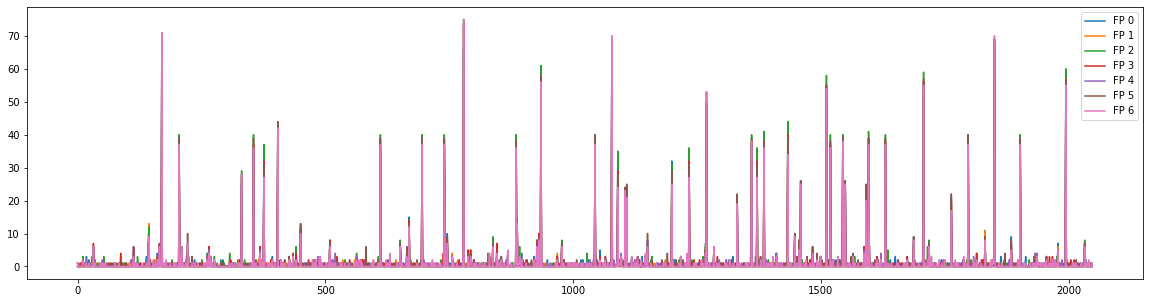

In [16]:
fig, ax = plt.subplots(figsize=(20, 5))

for i, entry in enumerate(entries):
    fp = proj_obj.get_entry_results(entry).ifp
    plot_vals = [fp.counts[i] if i in fp.counts else 0 for i in range(1, fp.fp_length + 1)]
    ax.plot(plot_vals, label = f"FP {i}")
plt.legend()

### Bit fingperprints

In [17]:
proj_obj = luna.projects.LocalProject(**opt, ifp_count = False)
proj_obj()

/srv/home/lshub/LUNA/luna/projects.py:266: UserWarning: Logging mode was set ON. Logging information will be saved from now on.
  warnings.warn("Logging mode was set ON. Logging information will be saved from now on.")


[2020-09-30 11:46:36]    PROGRESS                               100% [■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■] 7/7 [Avg: 95.71s/task; Errors: 0] - Entries processing.


#### Density - how populated is the fingerprint

(array([1., 1., 0., 0., 0., 1., 0., 0., 2., 2.]),
 array([0.10791016, 0.11030273, 0.11269531, 0.11508789, 0.11748047,
        0.11987305, 0.12226563, 0.1246582 , 0.12705078, 0.12944336,
        0.13183594]),
 <a list of 10 Patch objects>)

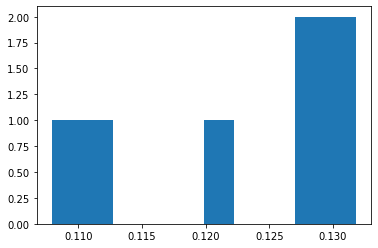

In [18]:
densities = [proj_obj.get_entry_results(entry).ifp.density for entry in entries]
plt.hist(densities)

#### Tanimoto coefficient - how similar are two fingerprints

In [19]:
def tanimoto(fp1, fp2):
    id1, id2 = set(fp1.indices), set(fp2.indices)
    i = id1.intersection(id2)
    u = id1.union(id2)
    return float(len(i))/len(u)

(array([1., 0., 0., 1., 0., 0., 1., 0., 0., 3.]),
 array([0.11663067, 0.12114738, 0.12566409, 0.13018079, 0.1346975 ,
        0.13921421, 0.14373092, 0.14824763, 0.15276434, 0.15728104,
        0.16179775]),
 <a list of 10 Patch objects>)

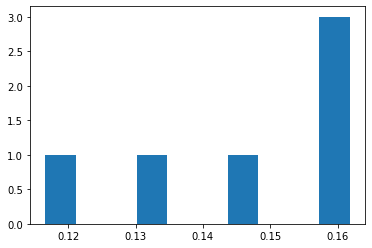

In [20]:
tanimotos = [tanimoto(proj_obj.get_entry_results(entries[0]).ifp, proj_obj.get_entry_results(entries[i]).ifp) 
             for i in range(1,7)]
plt.hist(tanimotos)

### Plotting interaction heatmaps

In [21]:
from luna.analysis.residues import calculate_residues_frequency
from luna.analysis.view import res_freq_heatmap

In [22]:
interaction_tuples = [(entry, proj_obj.get_entry_results(entry).interactions_mngr) for entry in entries]

In [23]:
rf = calculate_residues_frequency(interaction_tuples)

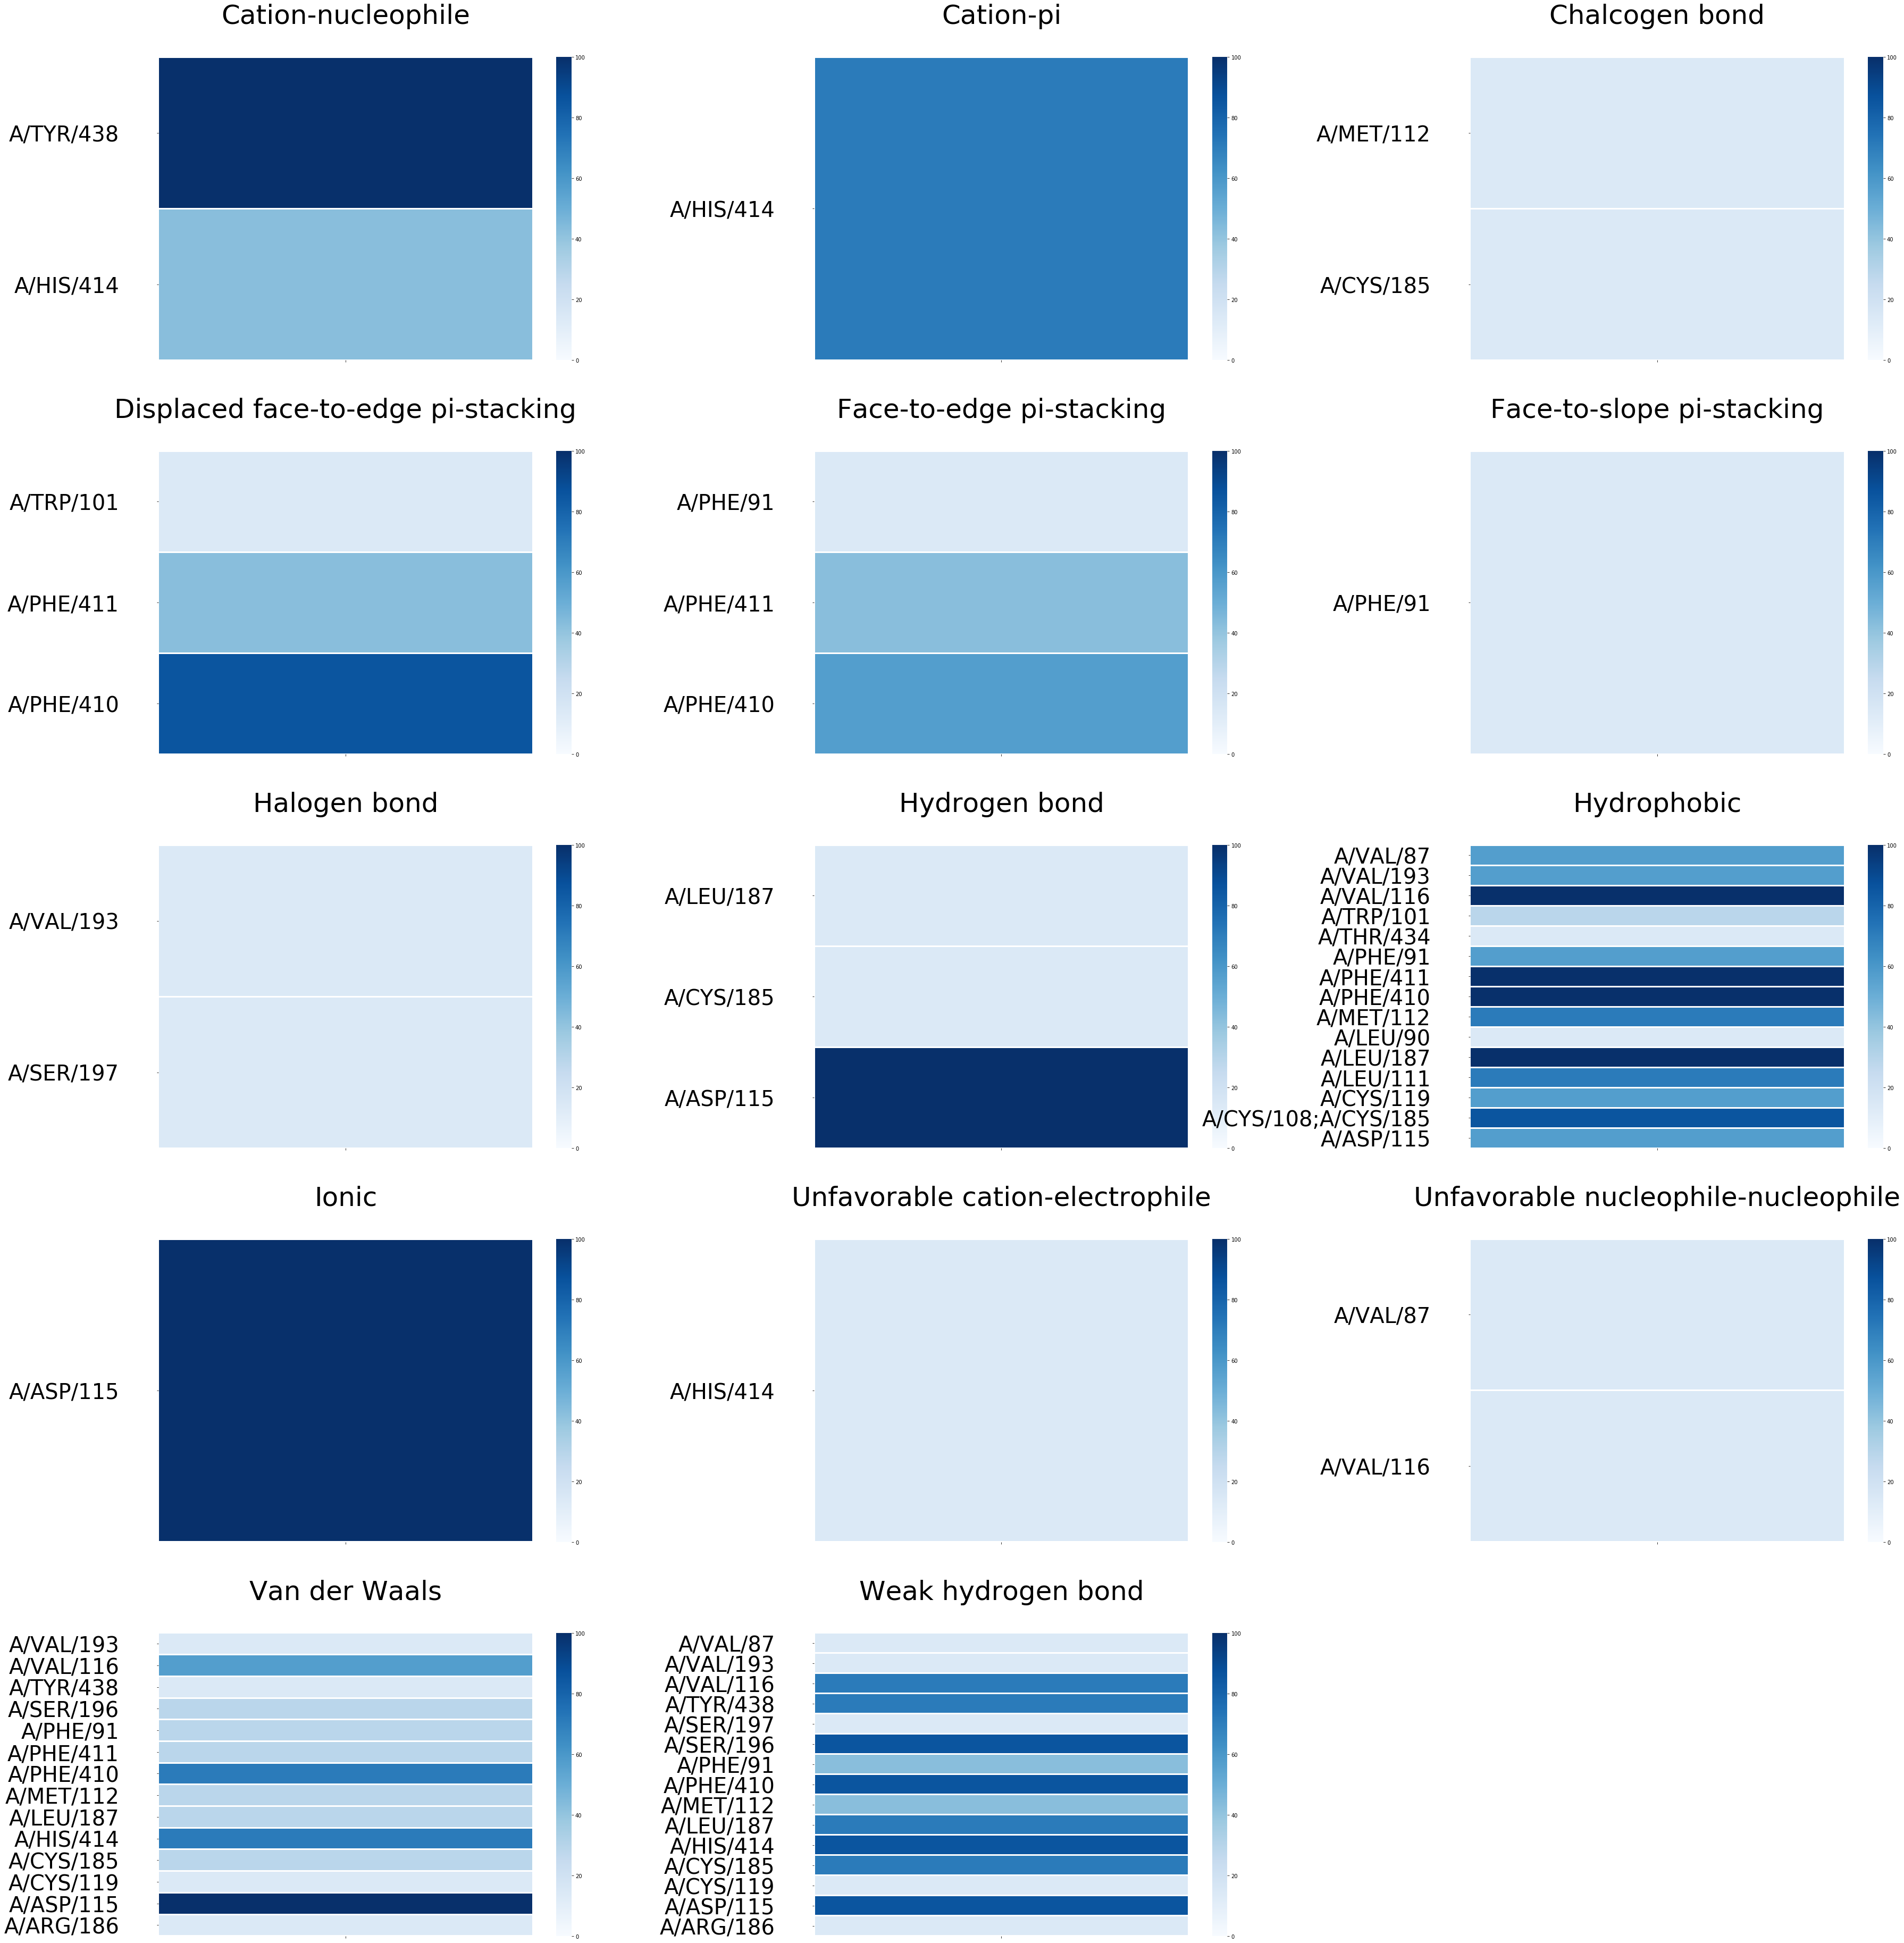

In [24]:
res_freq_heatmap(len(entries), rf, 'test')

## Plotting multiple pymol sessions

In [25]:
from luna.mol.interaction.view import InteractionViewer

In [26]:
for entry in entries:
    entry.pdb_file = "./inputs_multi/prot.pdb"

In [27]:
all_tuples = [(entry, proj_obj.get_entry_results(entry).interactions_mngr) for entry in entries]
pse_file = "./outputs/multi-lig-visualization-all.pse"

inter_view = InteractionViewer()
inter_view.new_session(all_tuples, pse_file)

 PyMOL not running, entering library mode (experimental)
HETATM    1  C1  LIG z9999     -17.119  15.694 -19.179  1.00  0.00           C  
HETATM    2  N1  LIG z9999     -18.165  16.406 -18.433  1.00  0.00           N  
HETATM    3  H1  LIG z9999     -18.485  15.830 -17.669  1.00  0.00           H  
HETATM    4  C2  LIG z9999     -17.618  17.662 -17.902  1.00  0.00           C  
HETATM    5  C3  LIG z9999     -16.463  17.359 -16.983  1.00  0.00           C  
HETATM    6  N2  LIG z9999     -15.314  17.975 -16.961  1.00  0.00           N  
HETATM    7  N3  LIG z9999     -14.565  17.457 -16.052  1.00  0.00           N  
HETATM    8  C4  LIG z9999     -15.217  16.483 -15.457  1.00  0.00           C  
HETATM    9  C5  LIG z9999     -14.714  15.636 -14.360  1.00  0.00           C  
HETATM   10  C6  LIG z9999     -15.162  14.299 -14.224  1.00  0.00           C  
HETATM   11  C7  LIG z9999     -16.089  13.748 -15.120  1.00  0.00           C  
HETATM   12  C8  LIG z9999     -16.498  12.458 -14.9

HETATM    1  C1  LIG z9999     -23.157  16.131 -19.117  1.00  0.00           C  
HETATM    2  C2  LIG z9999     -21.743  15.909 -18.575  1.00  0.00           C  
HETATM    3  C3  LIG z9999     -20.729  16.567 -19.513  1.00  0.00           C  
HETATM    4  H1  LIG z9999     -20.811  16.125 -20.505  1.00  0.00           H  
HETATM    5  C4  LIG z9999     -21.013  18.068 -19.599  1.00  0.00           C  
HETATM    6  N1  LIG z9999     -19.372  16.355 -18.993  1.00  0.00           N  
HETATM    7  H2  LIG z9999     -19.295  15.417 -18.629  1.00  0.00           H  
HETATM    8  C5  LIG z9999     -19.105  17.318 -17.917  1.00  0.00           C  
HETATM    9  C6  LIG z9999     -17.735  17.023 -17.297  1.00  0.00           C  
HETATM   10  N2  LIG z9999     -16.729  17.018 -18.370  1.00  0.00           N  
HETATM   11  C7  LIG z9999     -15.596  17.739 -18.261  1.00  0.00           C  
HETATM   12  O1  LIG z9999     -14.777  17.723 -19.157  1.00  0.00           O  
HETATM   13  C8  LIG z9999  

HETATM    1  C1  LIG z9999     -17.074  18.158 -19.426  1.00  0.00           C  
HETATM    2  C2  LIG z9999     -17.198  16.700 -18.978  1.00  0.00           C  
HETATM    3  H1  LIG z9999     -16.825  16.045 -19.766  1.00  0.00           H  
HETATM    4  C3  LIG z9999     -16.388  16.489 -17.725  1.00  0.00           C  
HETATM    5  N1  LIG z9999     -15.684  17.392 -17.102  1.00  0.00           N  
HETATM    6  N2  LIG z9999     -15.123  16.865 -16.071  1.00  0.00           N  
HETATM    7  C4  LIG z9999     -15.453  15.597 -16.000  1.00  0.00           C  
HETATM    8  C5  LIG z9999     -15.020  14.635 -14.964  1.00  0.00           C  
HETATM    9  C6  LIG z9999     -15.448  13.307 -15.019  1.00  0.00           C  
HETATM   10  C7  LIG z9999     -15.040  12.414 -14.050  1.00  0.00           C  
HETATM   11  C8  LIG z9999     -14.210  12.831 -13.025  1.00  0.00           C  
HETATM   12  C9  LIG z9999     -13.782  14.146 -12.964  1.00  0.00           C  
HETATM   13 CL1  LIG z9999  

HETATM    1  N1  LIG z9999     -15.519  10.785 -12.953  1.00  0.00           N  
HETATM    2  C1  LIG z9999     -15.001  11.777 -13.147  1.00  0.00           C  
HETATM    3  C2  LIG z9999     -14.347  13.028 -13.392  1.00  0.00           C  
HETATM    4  C3  LIG z9999     -13.304  13.468 -12.566  1.00  0.00           C  
HETATM    5  C4  LIG z9999     -12.699  14.678 -12.835  1.00  0.00           C  
HETATM    6  N2  LIG z9999     -13.088  15.421 -13.852  1.00  0.00           N  
HETATM    7  C5  LIG z9999     -14.069  15.046 -14.660  1.00  0.00           C  
HETATM    8  S1  LIG z9999     -14.539  16.087 -16.002  1.00  0.00           S  
HETATM    9  C6  LIG z9999     -16.280  16.451 -15.646  1.00  0.00           C  
HETATM   10  C7  LIG z9999     -16.845  17.360 -16.739  1.00  0.00           C  
HETATM   11  O1  LIG z9999     -15.897  18.375 -17.077  1.00  0.00           O  
HETATM   12  C8  LIG z9999     -18.174  17.998 -16.273  1.00  0.00           C  
HETATM   13  C9  LIG z9999  